https://www.kaggle.com/datasets/saurabhshahane/barkvn50

In [1]:
import matplotlib.pyplot as plt
from keras.layers import (
    Input, Dense, Conv2D, Flatten, Reshape, Dropout, 
    Activation, AveragePooling2D, BatchNormalization,
    Lambda, Concatenate
)
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

2023-01-14 14:49:15.704180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gen = ImageDataGenerator().flow_from_directory(
    'BarkVN-50/BarkVN-50_mendeley/', 
    class_mode='categorical',
)
gen

Found 5578 images belonging to 50 classes.


In [3]:
def WaveletTransform(img):
    low = img[:,::2,...] + img[:,1::2,...]
    low = low[:,:,::2,...] + low[:,:,1::2,...]
    high = img[:,::2,...] - img[:,1::2,...]
    high = high[:,:,::2,...] - high[:,:,1::2,...]
    return low, high

In [4]:
def conv_layer(_in, N):
    conv1 = Conv2D(N, kernel_size=(3,3), padding='same')(_in)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    conv2 = Conv2D(N, kernel_size=(3,3), strides=(2,2), padding='same')(relu1)
    norm2 = BatchNormalization()(conv2)
    relu2 = Activation('relu')(norm2)
    return relu2

In [6]:
def build_model(input_shape = (256, 256, 3), num_classes=50):
    _input = Input(input_shape)
    
    low1, high1 = Lambda(WaveletTransform, name='wavelet_1')(_input)
    low2, high2 = Lambda(WaveletTransform, name='wavelet_2')(low1)
    low3, high3 = Lambda(WaveletTransform, name='wavelet_3')(low2)
    low4, high4 = Lambda(WaveletTransform, name='wavelet_4')(low3)
    
    k1 = Concatenate()([conv_layer(_input,64), low1])
    k2 = Concatenate()([conv_layer(k1, 128), low2])
    k3 = Concatenate()([conv_layer(k2, 256), low3])
    k4 = Concatenate()([conv_layer(k3, 512), low4, high4])
    avg_pool = AveragePooling2D(pool_size=(7,7), strides=1, padding='same')(k4)
    flat = Flatten()(avg_pool)
    output = Dense(num_classes, activation='softmax',name='fc')(flat)
    model = Model(inputs=_input, outputs=output)
    return model

In [7]:
model = build_model()

2023-01-14 14:49:26.515837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

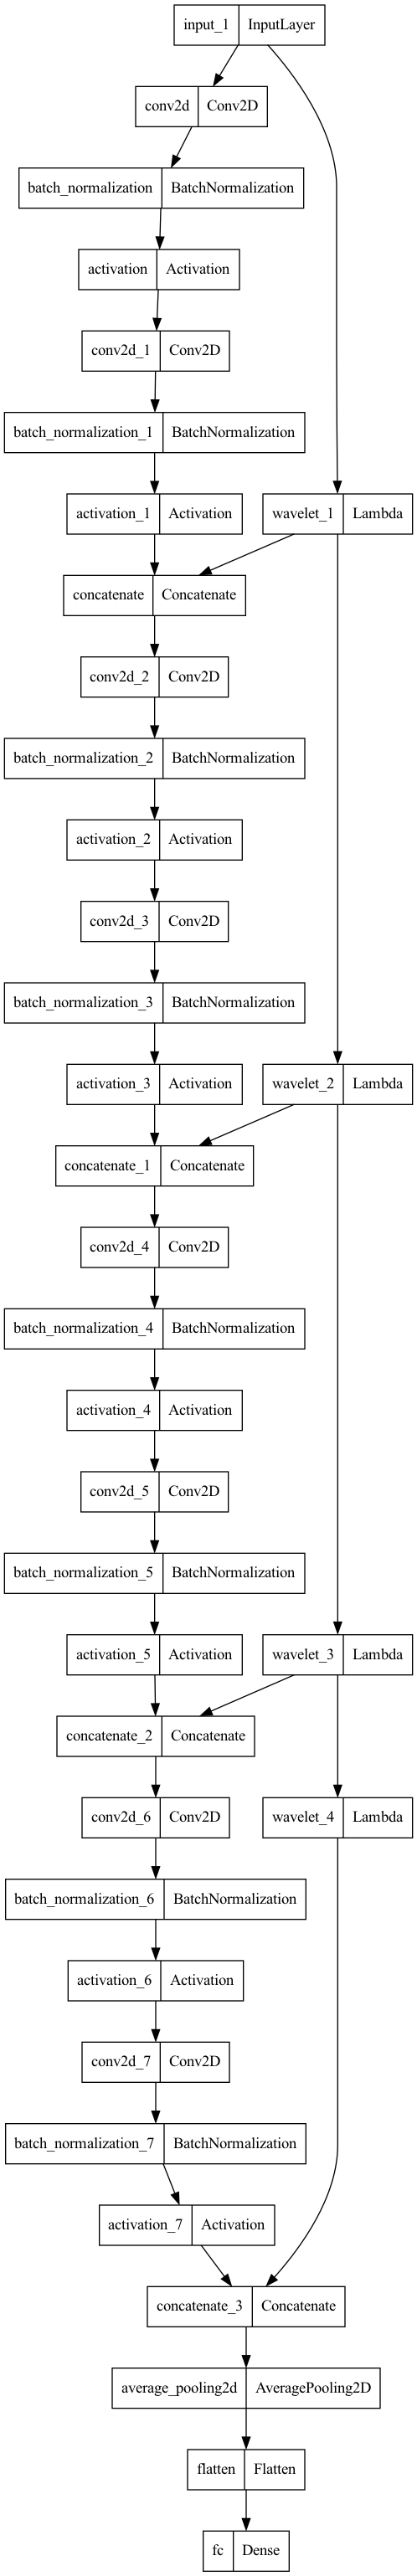

In [9]:
plot_model(model)

In [10]:
gen

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit(gen, epochs=1)

  7/175 [>.............................] - ETA: 1:19:38 - loss: 36008.4609 - accuracy: 0.0134